# Autoencoding

Data compression algorithm. An encoder network takes in an input, and converts it into a smaller, dense representation that constrains enough information, which the decoder network can use to convert it back to the original input. The encoder learns to preserve as much of the relevant information as possible

Autoencoders are data-specific, meaning they will only be able to compress data similar to what they have been trained on

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

In [2]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [3]:

from matplotlib import pyplot as plt,cm
def show_img(im,figsize=None,ax=None,cmap=cm.binary):
    if not ax: fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(im,cmap=cmap)
    return ax
def show_imgs(ims,figsize):   
    fig,axes=plt.subplots(2,5, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        ax=show_img(np.squeeze(ims[i]),ax=ax)
    plt.show()

In [4]:
def load_mnist(path, kind='train'):
    import os
    import struct
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [58]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')
y_train,y_test = y_train.astype(np.int64),y_test.astype(np.int64)
print('Training set size: {}'.format(X_train.shape))
print('Testing set size: {}'.format(X_test.shape))


Training set size: (60000, 784)
Testing set size: (10000, 784)


In [59]:
X_train = X_train.reshape([-1,28,28])
X_test = X_test.reshape([-1,28,28])

In [60]:
class FMNIST(Dataset):
    def __init__(self,X,y,transforms=None):
        self.X = X[:,:,:,None] # n,28,28 to n,28,28,1
        self.y = y
        self.n = len(X)
        self.transforms = transforms
    
    def __getitem__(self,index):
        img = self.X[index]
        label = self.y[index]
        if self.transforms is not None:
            img = self.transforms(img)
        return (img,label)
    
    def __len__(self):
        return self.n

In [61]:
tsfms = transforms.Compose([transforms.ToTensor()])
train_ds = FMNIST(X_train,y_train,tsfms)

In [9]:
train_ds = FMNIST(X_train,y_train,tsfms)
# train_dl = DataLoader(train_ds,batch_size=32,shuffle=False,num_workers=0)
# test_ds = FMNIST(X_test,y_test,tsfms)
# test_dl = DataLoader(test_ds,batch_size=32,shuffle=False,num_workers=0)

In [62]:

nm_mean = np.mean(train_ds.X)/255 # between 0 and 1
nm_std = np.std(train_ds.X)/255
print(nm_mean)
print(nm_std)

tsfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((nm_mean,),(nm_std,))])

train_ds = FMNIST(X_train,y_train,tsfms)
train_dl = DataLoader(train_ds,batch_size=32,shuffle=False,num_workers=0)
test_ds = FMNIST(X_test,y_test,tsfms)
test_dl = DataLoader(test_ds,batch_size=32,shuffle=False,num_workers=0)

0.2860405969887955
0.3530242445149223


# Define auto encoder

In [63]:
from torch.nn.init import kaiming_uniform, kaiming_normal
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),

            nn.ReLU(True),
            nn.Linear(128, 64),
 
            nn.ReLU(True), 
            nn.Linear(64, 32), 
            
            nn.ReLU(True), 
            nn.Linear(32, 16), 
            nn.ReLU(True), 
            nn.Linear(16, 3))
            
        self.decoder = nn.Sequential(
            nn.Linear(3, 16),

            nn.ReLU(True),
            nn.Linear(16, 32),

            nn.ReLU(True),
            nn.Linear(32, 64),
            
            nn.ReLU(True),
            nn.Linear(64, 128),
            
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
#             nn.Tanh()  # why tanh?
            nn.Sigmoid()
        )
        # todo: try kaiming normalization to see if it's better
    def forward(self,x):
        x= x.view(x.size(0),-1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [39]:
# def init_weights(w):
# #     print(w)
#     if isinstance(w, nn.Linear):
#         kaiming_normal(w.weight.data)

In [64]:
ac = AutoEncoder()

# ac.apply(init_weights)

In [65]:
optimizer = optim.Adam(ac.parameters(),lr=0.001)

In [66]:
def train(nb_epoch):
    for epoch in range(nb_epoch):
        print(f'Epoch {epoch+1}:')
        running_trn_loss=0
        for x,y in train_dl:
            inputs,labels = Variable(x),Variable(x)
            optimizer.zero_grad()
            enc,dec = ac(inputs)
            
            loss = F.mse_loss(dec,labels)
            running_trn_loss+=loss.data[0] * inputs.size(0)
            
            loss.backward()
            optimizer.step()
        print(f'Training Loss: {running_trn_loss/len(train_ds)}')
        
        x_show=np.squeeze(x[:5].numpy())
        dec_show = dec[:5].data.numpy().reshape([-1,28,28])
        concat = np.concatenate([x_show,dec_show],axis=0)
        show_imgs(concat,figsize=(10,4))

Epoch 1:
Training Loss: 0.6324163142840068


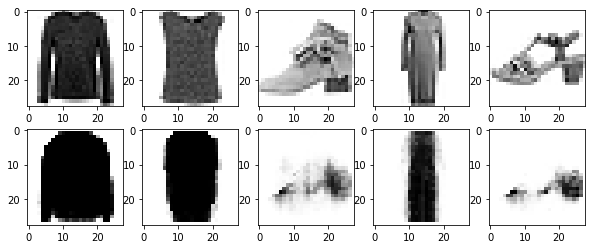

Epoch 2:
Training Loss: 0.560209920501709


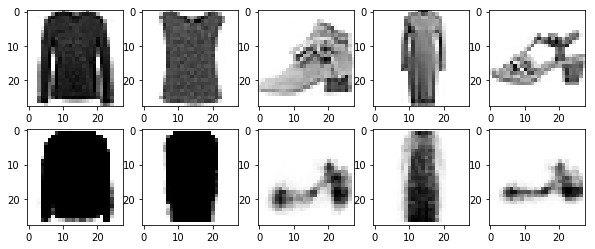

Epoch 3:
Training Loss: 0.5493035935084025


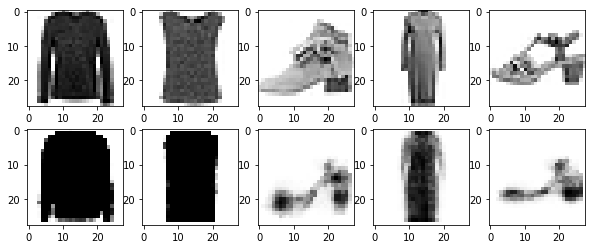

Epoch 4:
Training Loss: 0.5447768964767457


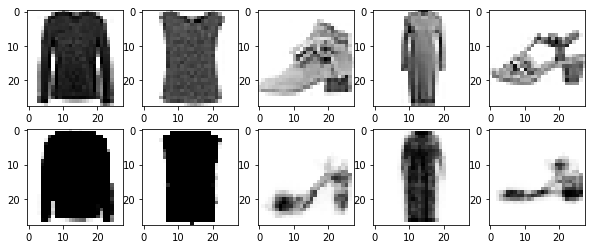

Epoch 5:
Training Loss: 0.54118473889033


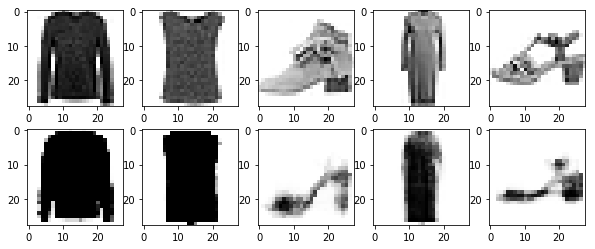

Epoch 6:
Training Loss: 0.5385864784876505


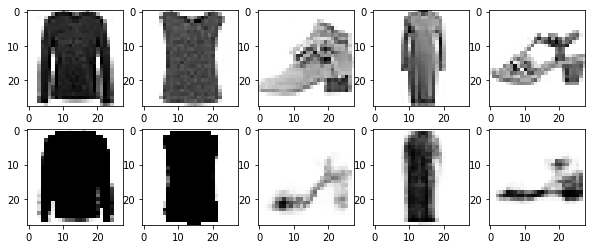

Epoch 7:
Training Loss: 0.5365250984191895


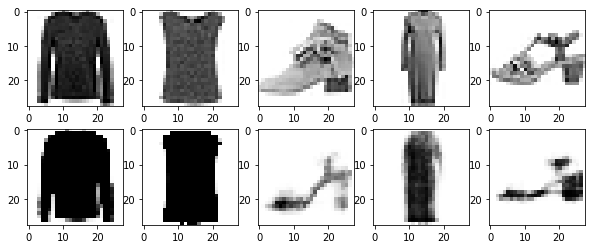

Epoch 8:
Training Loss: 0.5348115309874216


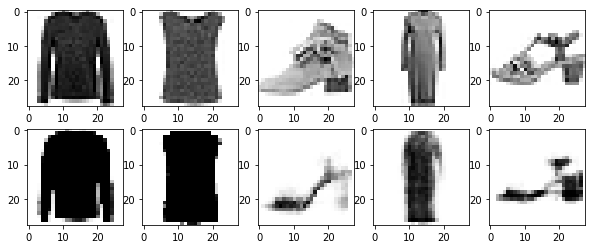

In [67]:
## bn
train(8)

Epoch 1:
Training Loss: 0.5333849308172862


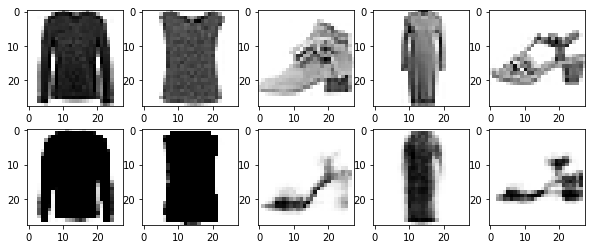

Epoch 2:
Training Loss: 0.5325597663720448


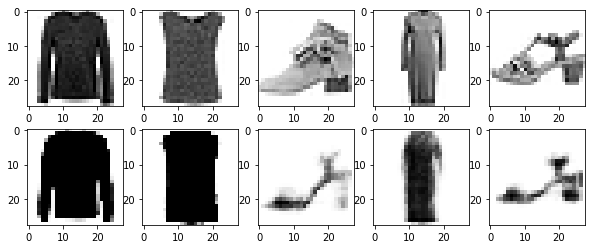

Epoch 3:
Training Loss: 0.5315310448010763


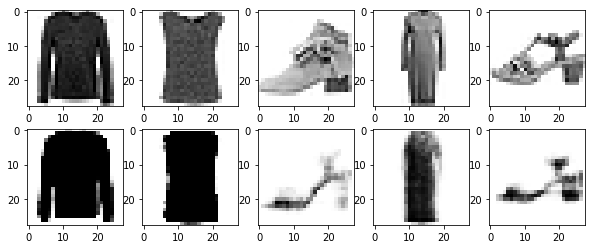

Epoch 4:
Training Loss: 0.5308041586558024


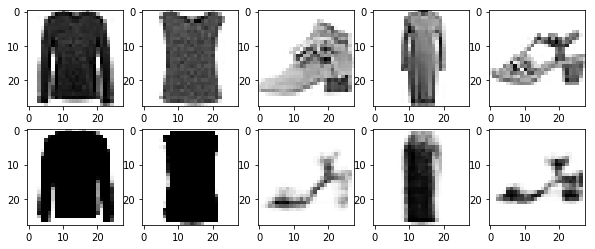

Epoch 5:
Training Loss: 0.5302500537554423


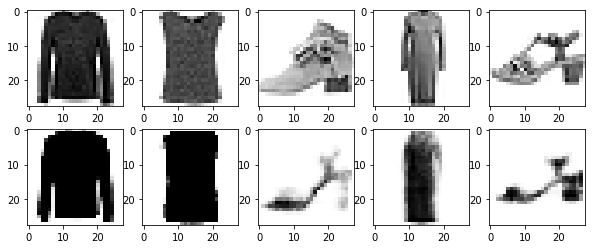

In [68]:
train(5)

# Understanding Encoder

We will visualize the output of encoder in AutoEncoder class. Since otuput of this encoder is 3, we can plot 3D graph to check for clusters

In [82]:
imgs = X_train[:200].reshape(-1,28*28)/255.
plot_imgs = Variable(torch.FloatTensor(imgs))

In [84]:
encoded_data, _ = ac(plot_imgs)

In [85]:
encoded_data.shape

torch.Size([200, 3])

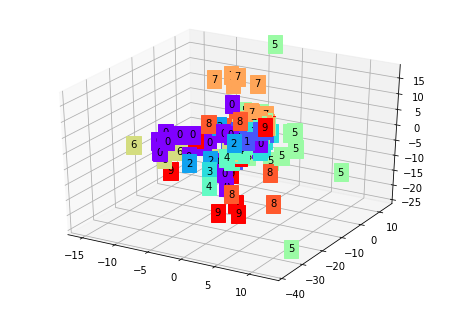

In [98]:
# %matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(2);
ax = Axes3D(fig)

X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = y_train[:200]
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

In [106]:
labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}

In [111]:
c_list = [cm.rainbow(int(255*i/9)) for i in range(10)]

In [119]:
df = pd.DataFrame({'X':X,'Y':Y,'Z':Z,'v': values})

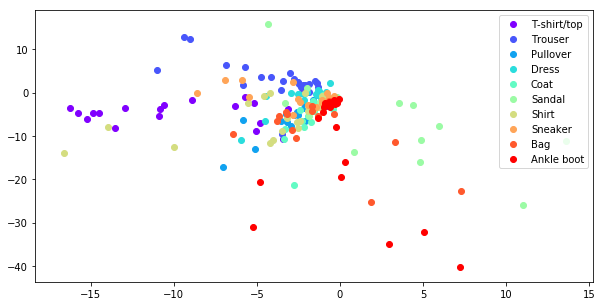

In [134]:
plt.figure(figsize=(10,5))
for i in range(10):
    df_i = df[df.v==i]
    c = cm.rainbow(int(255*i/9))
    plt.scatter(df_i.X, df_i.Y, c=c, marker = 'o',label=labels[i])
plt.legend()
plt.show()

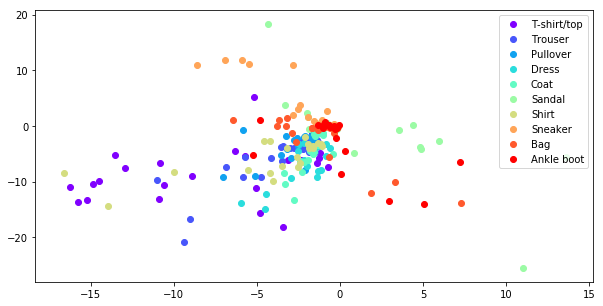

In [135]:
plt.figure(figsize=(10,5))
for i in range(10):
    df_i = df[df.v==i]
    c = cm.rainbow(int(255*i/9))
    plt.scatter(df_i.X, df_i.Z, c=c, marker = 'o',label=labels[i])
plt.legend()
plt.show()

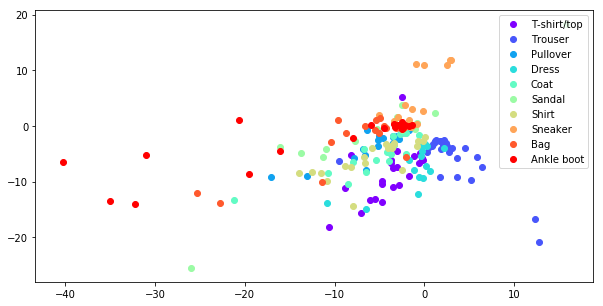

In [136]:
plt.figure(figsize=(10,5))
for i in range(10):
    df_i = df[df.v==i]
    c = cm.rainbow(int(255*i/9))
    plt.scatter(df_i.Y, df_i.Z, c=c, marker = 'o',label=labels[i])
plt.legend()
plt.show()